In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from collections import defaultdict

pd.set_option('future.no_silent_downcasting', True)

In [6]:
# Load the data
df = pd.read_csv("../data/heart.csv")
df.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
842,43,F,ASY,132,341,1,LVH,136,Y,3.0,Flat,1
432,63,M,ASY,170,177,0,Normal,84,Y,2.5,Down,1
871,61,M,NAP,150,243,1,Normal,137,Y,1.0,Flat,0
334,51,M,ASY,130,0,1,Normal,170,N,-0.7,Up,1
727,60,F,ASY,158,305,0,LVH,161,N,0.0,Up,1


In [7]:
df.shape

(918, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


There are 0 values in the Cholesterol and RestingBP columns, 0 Cholesterol or RestingBP is physiologically impossible, These are either missing values or human errors. Replace them with Nan.

In [10]:
# Check for duplicate rows
df.duplicated().sum()

np.int64(0)

In [11]:
# Get the categorical and numerical columns
num_cols, cat_cols = [], []

for col in df.columns:
    if df[col].nunique() <= 5:
        cat_cols.append(col)
    else:
        num_cols.append(col)
cat_cols.remove('HeartDisease')

print(f"Categorical features: {cat_cols}"ST_Slope)
print(f"Numerical features: {num_cols}")

Categorical features: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


Inspect the categorical features for missing values like ' ' or ? etc

In [12]:
for col in cat_cols:
    print(f'Categories in {col} column : {df[col].unique()}')

Categories in Sex column : ['M' 'F']
Categories in ChestPainType column : ['ATA' 'NAP' 'ASY' 'TA']
Categories in FastingBS column : [0 1]
Categories in RestingECG column : ['Normal' 'ST' 'LVH']
Categories in ExerciseAngina column : ['N' 'Y']
Categories in ST_Slope column : ['Up' 'Flat' 'Down']


As we can see there are no missing values of any sorts in these categorical columns.  

Check the number of missing values in Cholesterol and RestingBP

In [13]:
RestingBP_missing = (df['RestingBP'] == 0).sum()
Cholesterol_missing = (df['Cholesterol'] == 0).sum()
print(f'RestingBP has {RestingBP_missing} missing values which is {RestingBP_missing/df.shape[0]*100:.2f}% of the rows')
print(f'Cholesterol has {Cholesterol_missing} missing values which is {Cholesterol_missing/df.shape[0]*100:.2f}% of the rows')

RestingBP has 1 missing values which is 0.11% of the rows
Cholesterol has 172 missing values which is 18.74% of the rows


In [15]:
# Replace the missing value in RestingBP with mean value.
df['RestingBP'] = df['RestingBP'].replace({0:df['RestingBP'].mean()}) 

RestingBP has only a single missing value hence how we impute it wouldn't have a major affect on the data.
On the other hand Cholesterol column has 172 missing values, which needs to be taken care of with proper imputation.

From a medical perspective one would expect Cholesterol (LDL + HDL) to have a mild position correlation with the probability of having Heart disease. Let's check the correlation of Cholesterol column with HeartDisease column. 

Let's try different ways of imputing the values in Cholesterol column to make it as indicative of HeartDisease as possible.

Methods to try :

- Drop the rows containing missing values.
- Impute them with mean or median of the non-null values.
- Use KNN to impute the values.

In [16]:
# Correlation of Cholesterol and HeartDisease before any imputation.
before_corr = round(df['Cholesterol'].corr(df['HeartDisease']), 3)


In [17]:
# Find the correlation if we drop these rows.
drop_corr = round(df[df['Cholesterol'] != 0]['Cholesterol'].corr(df[df['Cholesterol'] != 0]['HeartDisease']), 3)


In [18]:
# Find the correlation if we impute missing values wth mean
mean_chol = df['Cholesterol'].replace({0:np.nan}).mean()
mean_corr = round(df['Cholesterol'].replace({0:np.nan}).fillna(mean_chol).corr(df['HeartDisease']), 3)

In [19]:
# Find the correlation if we impute missing values wth mean
median_chol = df['Cholesterol'].replace({0:np.nan}).median()
median_corr = round(df['Cholesterol'].replace({0:np.nan}).fillna(median_chol).corr(df['HeartDisease']), 3)

In [25]:
# Find the correlation after using KNNImputer.
temp_df = df.copy()
temp_df['Cholesterol'] = temp_df['Cholesterol'].replace({0:np.nan})
knnimputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
temp_df[num_cols] = knnimputer.fit_transform(temp_df[num_cols])

knn_corr = round(temp_df['Cholesterol'].corr(temp_df['HeartDisease']), 3)

Compare the correlations after different imputations.

In [26]:
corr_df = pd.DataFrame({
                        'before_corr':[before_corr], 
                        'drop_corr':[drop_corr], 
                        'mean_corr':mean_corr, 
                        'median_corr':median_corr,
                        'knn_corr':knn_corr
        })

corr_df

,before_corr,drop_corr,mean_corr,median_corr,knn_corr
0,-0.233,0.104,0.094,0.076,0.096


As we can see the correlation between Cholesterol and probability of having a HeartDisease is highest when we drop the columns, but
we need to check if dropping the missing rows would affect the correlation of other features with the HeartDisease column.

To inspect the effect of dropping the missing values on the correlation of other features with HeartDisease let's create a dataframe containing the before and after correlations of different numerical features.

In [18]:
df_after_drop = df.select_dtypes(include='number')

# Drop the missing values in the after df
df_after_drop['Cholesterol'] = df_after_drop['Cholesterol'].replace({0:np.nan})
df_after_drop.dropna(inplace=True)

# Create a dictionary to store the required info (correlation before and after dropping misising values)
corr_df = defaultdict(list)
columns = df.select_dtypes(include='number').columns.to_list()
columns.remove('HeartDisease')

for col in columns:
    corr_before_drop = round(df[col].corr(df['HeartDisease']), 3)
    corr_after_drop = round(df_after_drop[col].corr(df_after_drop['HeartDisease']), 3)
    corr_df['feature'].append(col)
    corr_df['corr_before_drop'].append(corr_before_drop)
    corr_df['corr_after_drop'].append(corr_after_drop)
    corr_df['difference'].append(abs(corr_after_drop-corr_before_drop))

In [19]:
corr_df = pd.DataFrame(corr_df)
corr_df

,index,corr_before_drop,corr_after_drop,difference
0,Age,0.282,0.299,0.017
1,RestingBP,0.118,0.173,0.055
2,Cholesterol,-0.233,0.104,0.337
3,FastingBS,0.267,0.161,0.106
4,MaxHR,-0.400,-0.377,0.023
5,Oldpeak,0.404,0.496,0.092


As we can see There is no major affect on the numerical columns' correlations with HeartDisease after dropping the missing values.

This notebook is dedicated for EDA and not to make any structural changes to the actual dataset itself, all the changes to data will be done in the '02_modeling_and_evaluation.ipynb' notebook based on the insights drawn from the current notebook.

In [30]:
# Let's drop the missing value rows and create a temporary dataframe for EDA.
eda_df = df.copy()
eda_df['Cholesterol'] = eda_df['Cholesterol'].replace({0:np.nan})
eda_df.dropna(inplace=True)
eda_df['RestingBP'] = eda_df['RestingBP'].replace({0:eda_df['RestingBP'].mean()})

In [31]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    float64
 4   Cholesterol     746 non-null    float64
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 75.8+ KB


## EDA
### Univariate Analysis

#### Check for class imbalance in the target varible

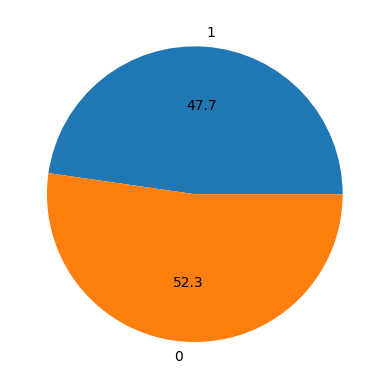

In [40]:
data = [eda_df['HeartDisease'].sum(), 746-eda_df['HeartDisease'].sum()]
labels = ['1', '0']
plt.pie(data, labels=labels, autopct='%.1f')
plt.show()

There's not a significant difference in the number of examples of each of the classes.

### Categorical features

Let's make barplots of categorical features to compare the probability of having a heart disease amongst different categories of each feature (ex : compare the probabilty of males and females getting a heart disease).

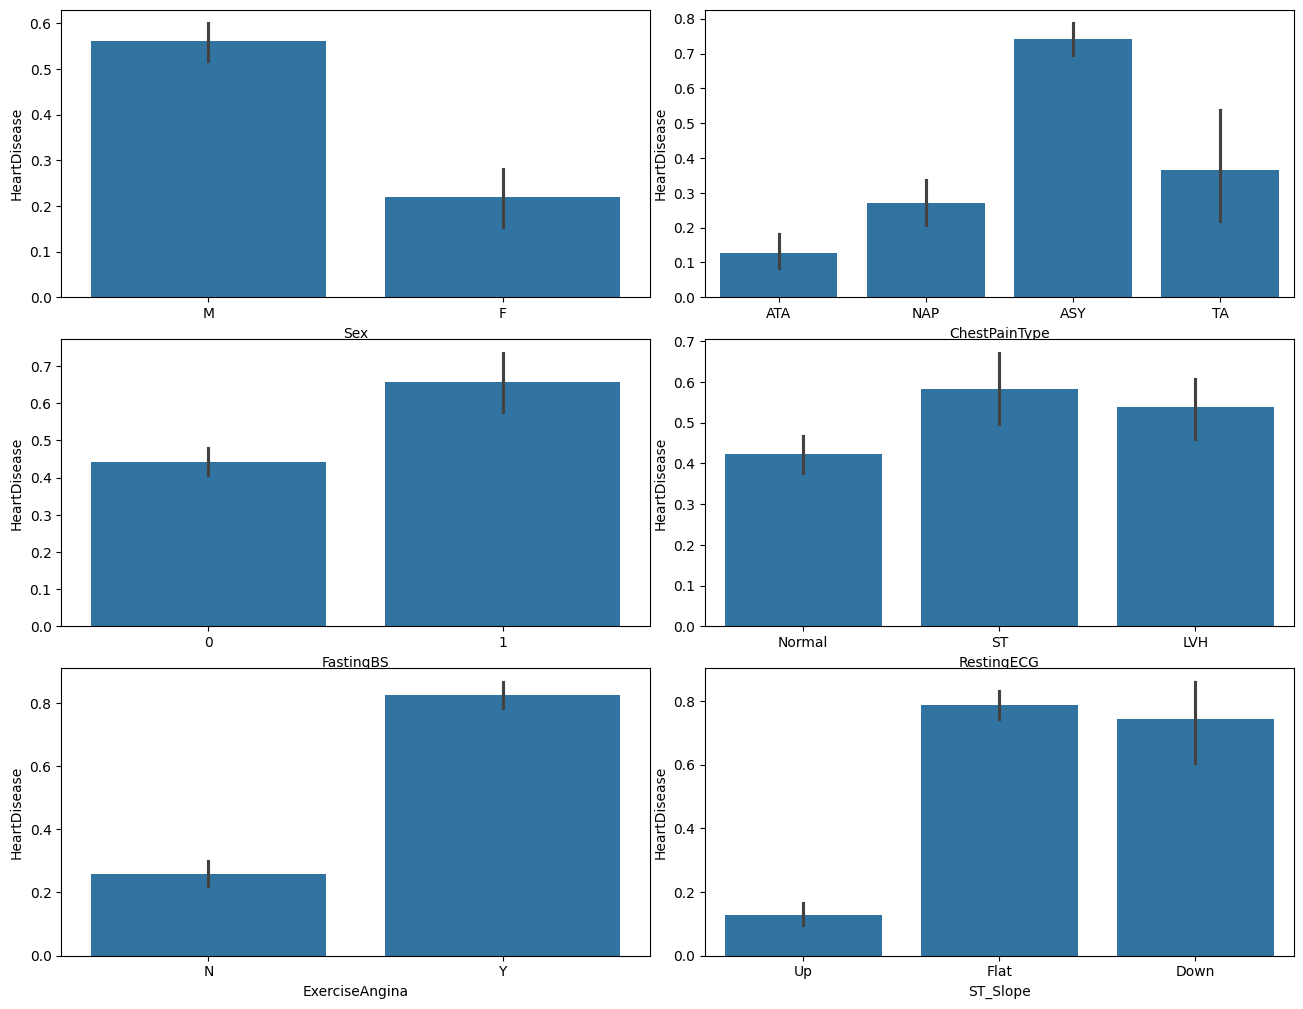

In [22]:
fig, axes = plt.subplots(3,2 , figsize=(13, 10))
fig.tight_layout(pad=0.9)
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.barplot(x=eda_df[col],y=eda_df['HeartDisease'], ax=axes[i])

In [33]:
# Calculate the probability of HeartDisease for each category of all the features.
print('The probabilities of Heart disease for each category of all the categorical features.')
print('_'*85)
print()
for col in cat_cols:
    probs = eda_df.groupby(col).agg({'HeartDisease':'mean'})
    print(probs)
    print('-'*50)

The probabilities of Heart disease for each category of all the categorical features.
_____________________________________________________________________________________

     HeartDisease
Sex              
F        0.219780
M        0.560284
--------------------------------------------------
               HeartDisease
ChestPainType              
ASY                0.740541
ATA                0.126506
NAP                0.272189
TA                 0.365854
--------------------------------------------------
           HeartDisease
FastingBS              
0              0.441224
1              0.656000
--------------------------------------------------
            HeartDisease
RestingECG              
LVH             0.539773
Normal          0.422472
ST              0.584000
--------------------------------------------------
                HeartDisease
ExerciseAngina              
N                   0.259259
Y                   0.825784
----------------------------------------------

We can see that the features **ST_Slope**, **RestingECG**, **ChestPainType** have categories with very low difference in probability (<=0.1) of having a heart disease.<br>
Potential strategy for modeling : Merge the categories with similar probabilities (for example: merge the 'Flat' and 'Down' categories in ST_slope) 

People with normal and LVH results of ECG seem to have similar probabilities of having a heart disease, we could try combining them before training.
People having Flat and Down ST_Slope seem to have similar probabilities of having and heart disease.

### Numerical Features

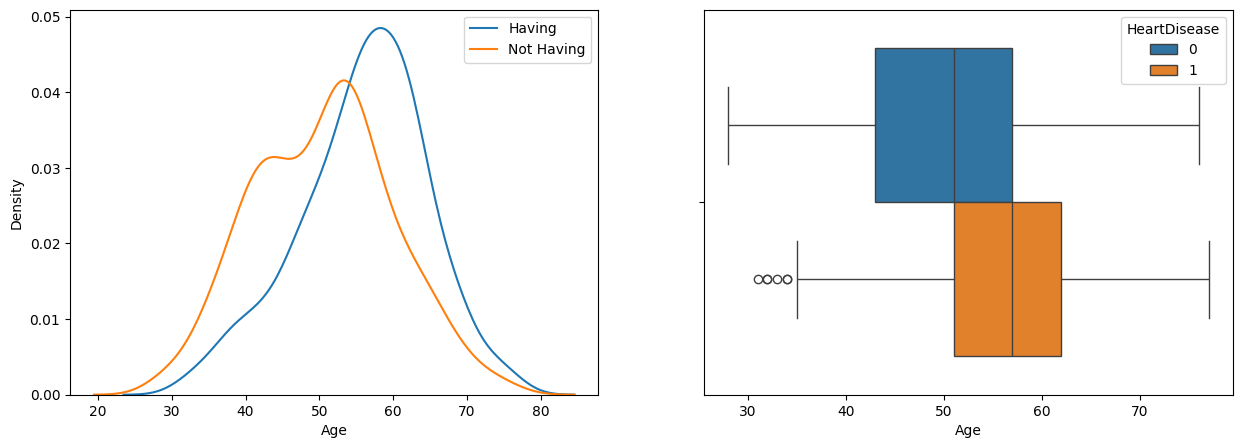

In [32]:
# Age.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

# Distribution of age of people having and not having the risk of heart disease.
sns.kdeplot(df[df['HeartDisease']==1]['Age'], label='Having', ax=axes[0])
sns.kdeplot(df[df['HeartDisease']==0]['Age'], label='Not Having', ax=axes[0])
axes[0].legend()

# Boxplot of age to identify potential outliers.
sns.boxplot(x=df['Age'], hue=df['HeartDisease'], ax=axes[1])

plt.show()

From the distribution, younger people have lesser probability of having a heart disease compared older people. There are not many potential outliers.

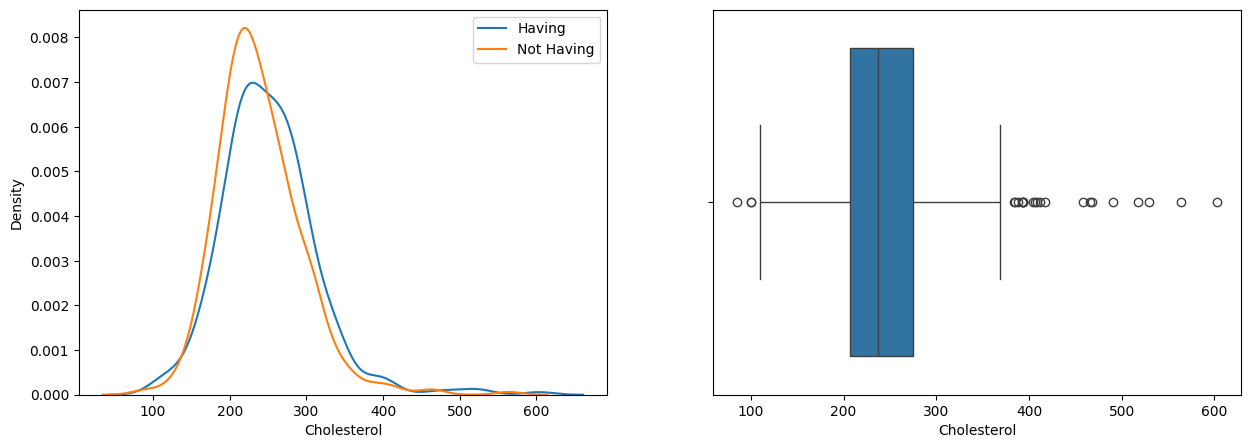

Number of potential outliers : 23


In [45]:
# Cholesterol
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

# Distribution of cholesterol of people having and not having the risk of heart disease.
sns.kdeplot(eda_df[eda_df['HeartDisease']==1]['Cholesterol'], label='Having', ax=axes[0])
sns.kdeplot(eda_df[eda_df['HeartDisease']==0]['Cholesterol'], label='Not Having', ax=axes[0])
axes[0].legend()

# Boxplot of age to identify potential outliers.
sns.boxplot(x=eda_df['Cholesterol'], ax=axes[1])

plt.show()

Q1 = eda_df['Cholesterol'].quantile(0.25)
Q3 = eda_df['Cholesterol'].quantile(0.75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

n_outliers = (eda_df['Cholesterol'] > upper_whisker).sum()
n_outliers += (eda_df['Cholesterol'] < lower_whisker).sum()

print(f'Number of potential outliers : {n_outliers}')

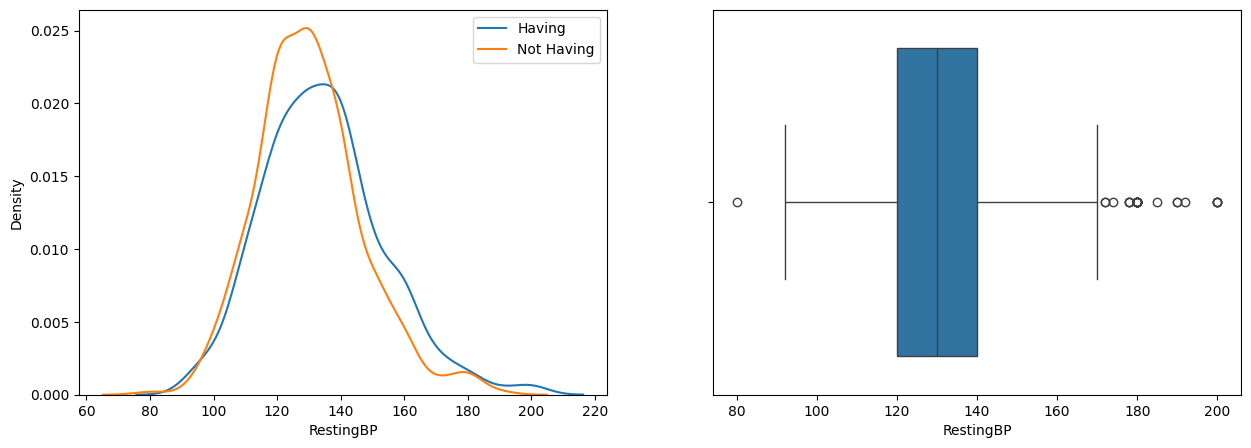

Number of potential outliers : 20


In [39]:
# RestingBP
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

# Distribution of RestingBP of people having and not having the risk of heart disease.
sns.kdeplot(df[df['HeartDisease']==1]['RestingBP'], label='Having', ax=axes[0])
sns.kdeplot(df[df['HeartDisease']==0]['RestingBP'], label='Not Having', ax=axes[0])
axes[0].legend()

# Boxplot of age to identify potential outliers.
sns.boxplot(x=df['RestingBP'], ax=axes[1])

plt.show()

Q1 = eda_df['RestingBP'].quantile(0.25)
Q3 = eda_df['RestingBP'].quantile(0.75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

n_outliers = (eda_df['RestingBP'] > upper_whisker).sum()
n_outliers += (eda_df['RestingBP'] < lower_whisker).sum()

print(f'Number of potential outliers : {n_outliers}')

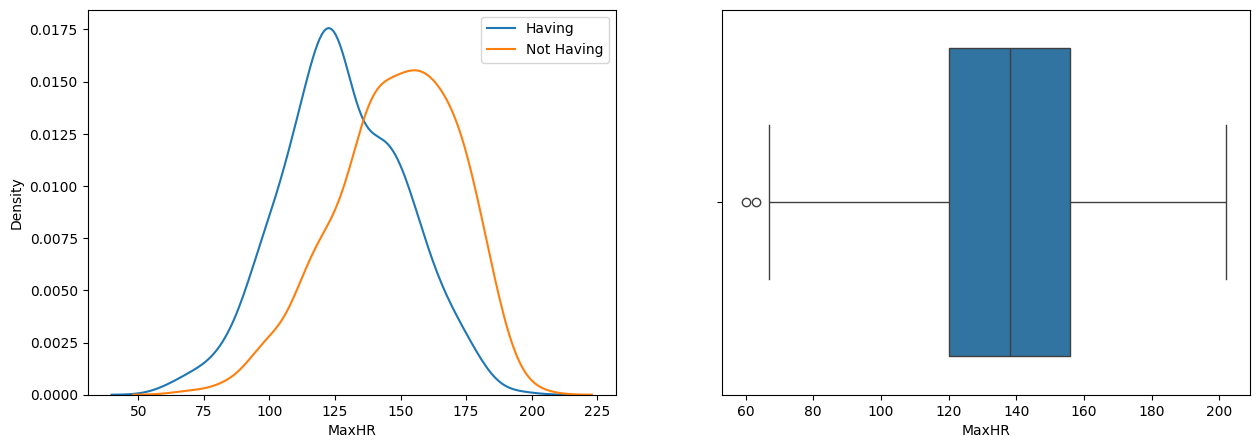

Number of potential outliers : 0


In [43]:
# MaxHR
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

# Distribution of MaxHR of people having and not having the risk of heart disease.
sns.kdeplot(df[df['HeartDisease']==1]['MaxHR'], label='Having', ax=axes[0])
sns.kdeplot(df[df['HeartDisease']==0]['MaxHR'], label='Not Having', ax=axes[0])
axes[0].legend()

# Boxplot of age to identify potential outliers.
sns.boxplot(x=df['MaxHR'], ax=axes[1])

plt.show()

Q1 = eda_df['MaxHR'].quantile(0.25)
Q3 = eda_df['MaxHR'].quantile(0.75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

n_outliers = (eda_df['MaxHR'] > upper_whisker).sum()
n_outliers += (eda_df['MaxHR'] < lower_whisker).sum()

print(f'Number of potential outliers : {n_outliers}')

### Multivariate Analysis

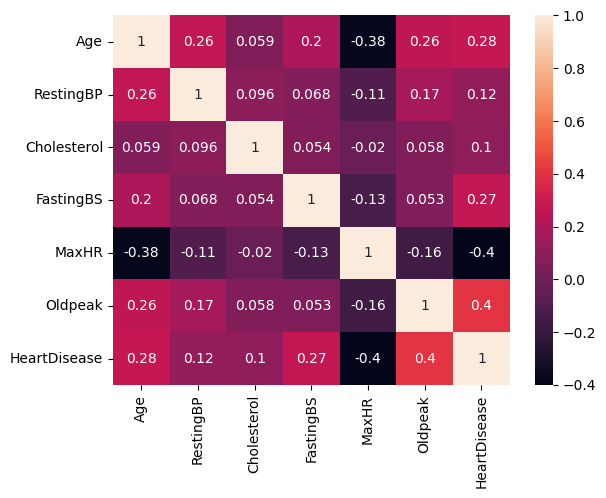

In [36]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.show()

No two features have a high magnitude of correlation, suggesting that each feature is giving different kinds of information.

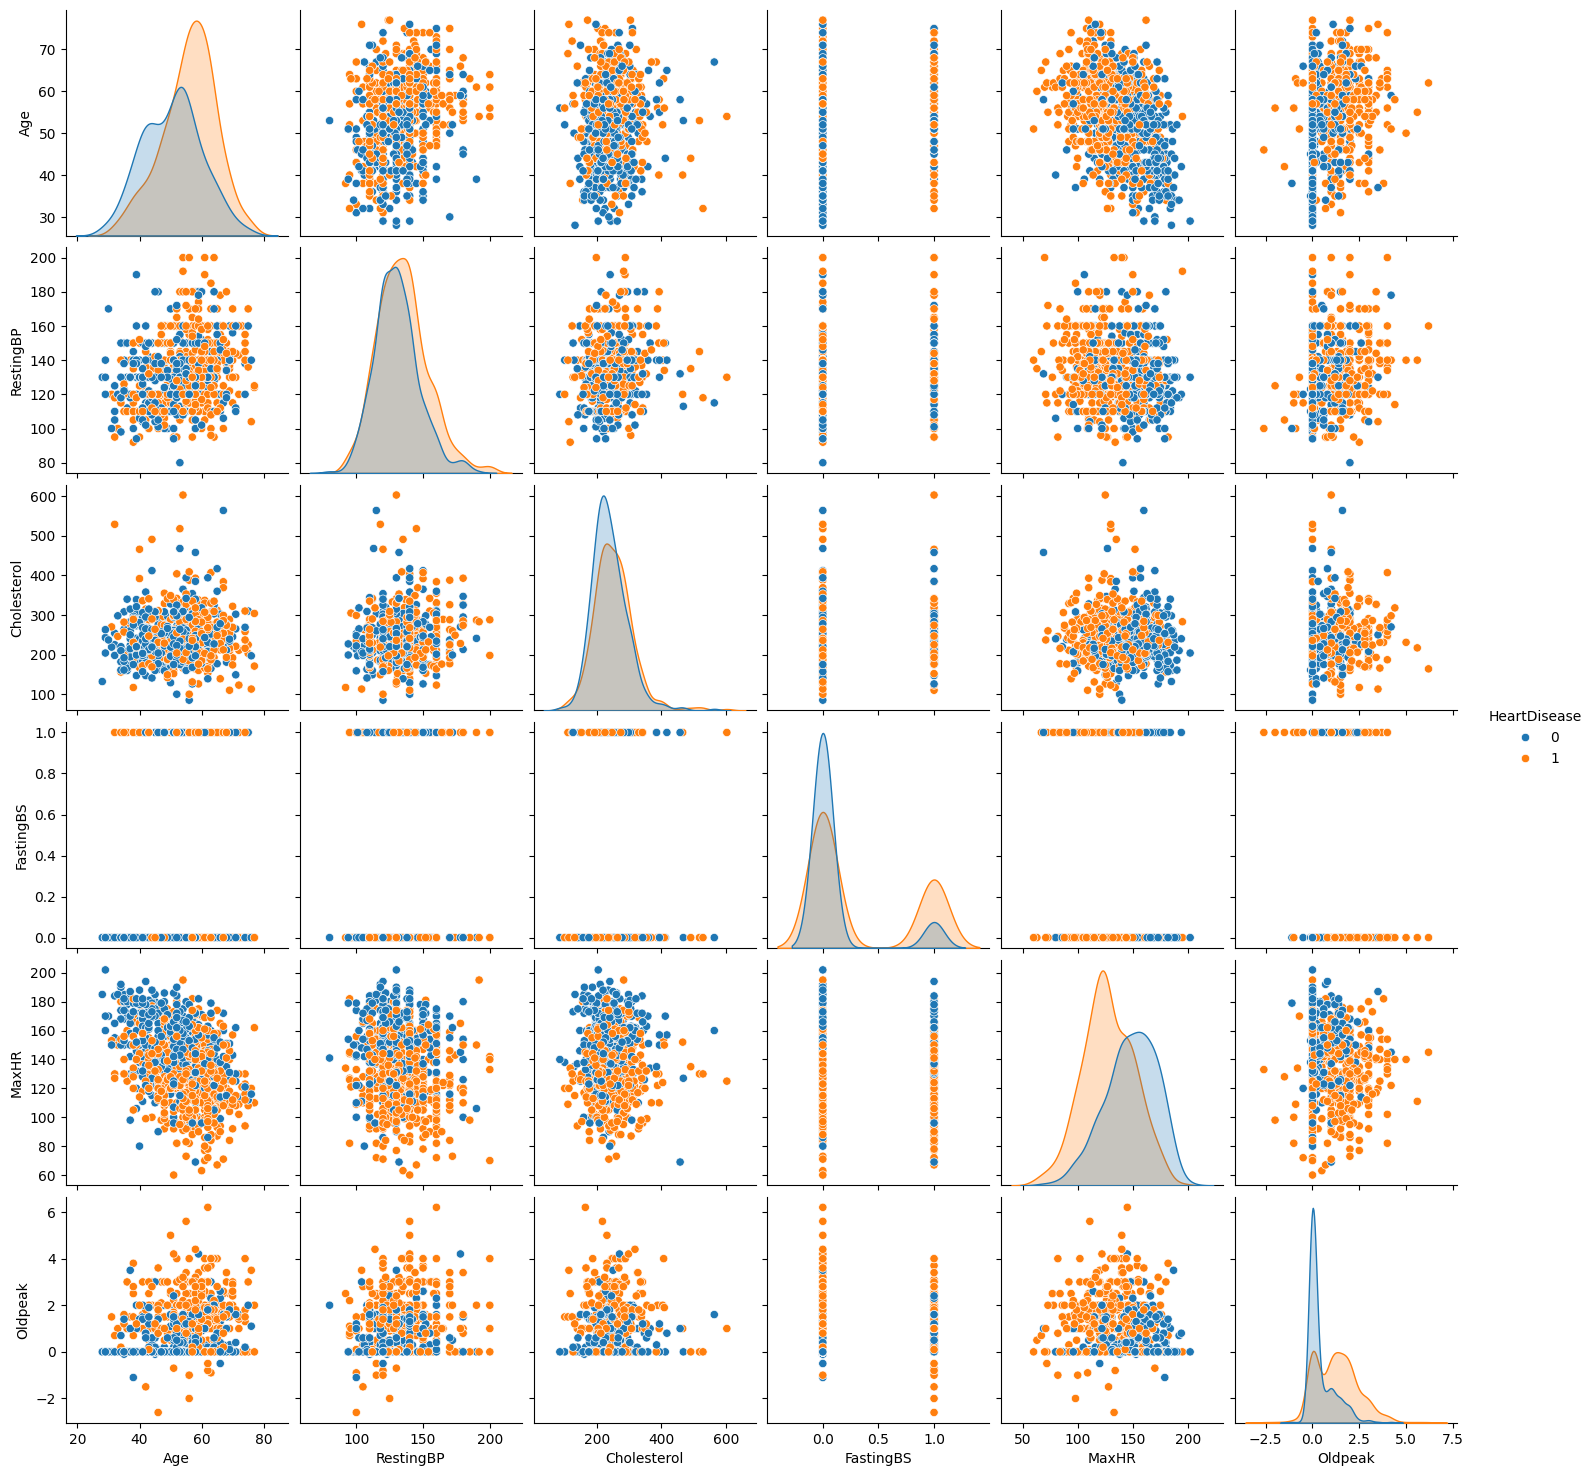

In [27]:
sns.pairplot(df, hue='HeartDisease')
plt.show()

## Summary
#### 1. Handling Missing Values :
- We found that dropping the missing-value rows in the **Cholesterol** column has increased the correlation of it with
  **HeartDisease** column and doing this didn't affect the correlations of other features w.r.t **HeartDisease** significantly.

#### 2. Conclusions from EDA :
- The categorical features such as **RestingECG**, **ChestPainType** and **ST_Slope** each have some categories with very similar probabilities of having a heart disease, these categories can be merged.
- No two features are highly correlated indicating that all the features are giving different kinds of info.
- Very few potential outliers were found in some of the numerical features like **Cholesterol** and **RestingBP** from the boxplots
- The numerical features seem to be fine (close to normal distribution).

#### 3. Transform the features before training :

We need to encode (Ordinal or OneHotEncode) the categorical features based on the kind of relations the classes in these features have amongst themselves.

- ChestPainType - The categories in this feature represent severity of chest pain<br>
       Increasing order of severity : TA < ATA < NAP < ASY.
- RestingECG - The categories in this feature do not have any kind of ordering in terms of severity or any other aspect.
- ST_Slope - The categories in this feature have an ordering in terms of severity of ***ischemia*** (insufficiency of blood supply to the        heart)
       Increasing order of severity : Up < Flat < Down.
- Sex - Only has two categories ('M' and 'F') with no ordering, so simple binary encoding F - 1 and M - 0 would be enough.
- ExerciseAgina - This feature has only two categories ('N' and 'Y') binary encoding would be enough.

1. The features **ChestPainType** and **ST_Slope** require Ordinal encoding.
2. **RestingECG** should be  One-Hot encoded.
3. **Sex** and **ExerciseAngina** should be binary encoded and FastingBS column is already binary encoded.